# Weather classification in image

## 가중치, csv저장 경로 설정

In [ ]:
save_best_path = '/content/drive/MyDrive/CarCrash_image/model_checkpoint/best_weather_model_0609_익균.pth'
save_submit_path = '/content/drive/MyDrive/CarCrash_image/model_checkpoint/weather_resnet50_submit_0609_익균.csv'

## Configuration

In [ ]:
CFG = {
    'VIDEO_LENGTH':50, # 10프레임 * 5초
    'IMG_SIZE':128,
    'EPOCHS':50,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':16,
    'SEED':1204
}

## 패키지 로딩

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plat
from PIL import Image
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/CarCrash_image/train.zip'

# 압축 해제할 경로 입력(드라이브 밖에 폴더로 설정해야함)
extraction_dir = '/content/data'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# zip_file_path = '/content/drive/MyDrive/image classification/open.zip'
# extract_to_path = '/content/data'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)

In [ ]:
zip_file_path = '/content/drive/MyDrive/image classification/open.zip'
extract_to_path = '/content/data1'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

### 원본 csv파일 수정

In [ ]:
'''
import pandas as pd
v_df = pd.read_csv('/content/drive/MyDrive/my_data/open/train.csv')

# sample_id가 삭제할 리스트에 포함되지 않는 경우만 추출하여 새로운 데이터프레임 생성
v_df['video_path'] = v_df['video_path'].str.replace('./train', '/content/drive/MyDrive/my_data/open/train')
v_df = v_df.drop(v_df[v_df['label'] == 0].index)
v_df
'''

"\nimport pandas as pd\nv_df = pd.read_csv('/content/drive/MyDrive/my_data/open/train.csv')\n\n# sample_id가 삭제할 리스트에 포함되지 않는 경우만 추출하여 새로운 데이터프레임 생성\nv_df['video_path'] = v_df['video_path'].str.replace('./train', '/content/drive/MyDrive/my_data/open/train')\nv_df = v_df.drop(v_df[v_df['label'] == 0].index)\nv_df\n"

### 비디오에서 프레임을 추출해 이미지로 저장

In [ ]:
import cv2
import os
import pandas as pd
import csv

def extract_frames(video_path, output_folder, sample_id, label, csv_writer):
    # 동영상 파일 열기
    cap = cv2.VideoCapture(video_path)

    # 프레임 카운터 초기화
    count = 0

    # 출력 폴더가 없으면 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    while True:
        # 프레임 읽기
        ret, frame = cap.read()
        if not ret:
            break

        # 프레임 파일명 생성
        frame_filename = f'{sample_id}_frame_{count:04d}.jpg'
        frame_path = os.path.join(output_folder, frame_filename)

        # 프레임을 이미지 파일로 저장
        success = cv2.imwrite(frame_path, frame)
        if success:
            # CSV 파일에 기록
            csv_writer.writerow([frame_filename, frame_path, label])
        else:
            print(f"Failed to write {frame_path}")

        # 프레임 카운터 증가
        count += 1

    # 동영상 파일 닫기
    cap.release()
    print(f"Extracted {count} frames from {video_path} and saved to {output_folder}")

In [ ]:
# CSV 파일 경로
csv_file_path = '/content/data1/train.csv'
df = pd.read_csv(csv_file_path)

def update_path(old_path):
    return old_path.replace('./train/', '/content/data1/train/')

df['video_path'] = df['video_path'].apply(update_path)

# label 업데이트
df.loc[df['sample_id'].str.contains('TRAIN_2236|TRAIN_2596'), 'label'] = 0
df.loc[df['sample_id'].str.contains('TRAIN_0061|TRAIN_0107|TRAIN_0123|TRAIN_0294|TRAIN_0800|TRAIN_1280|TRAIN_1590|TRAIN_2302|TRAIN_2548'), 'label'] = 1
df.loc[df['sample_id'].str.contains('TRAIN_0056|TRAIN_0129|TRAIN_0149|TRAIN_0242|TRAIN_0263|TRAIN_0728|TRAIN_0861|TRAIN_0889|TRAIN_0896|TRAIN_0920|TRAIN_1098|TRAIN_1169|TRAIN_1251|TRAIN_1605|TRAIN_1654|TRAIN_1656|TRAIN_1698|TRAIN_1795|TRAIN_1839|TRAIN_1955|TRAIN_2249|TRAIN_2388|TRAIN_2647'), 'label'] = 3
df.loc[df['sample_id'].str.contains('TRAIN_0221|TRAIN_0856|TRAIN_1081|TRAIN_1263|TRAIN_1488|TRAIN_1492|TRAIN_1874|TRAIN_2166|TRAIN_2555|TRAIN_2595|TRAIN_2622'), 'label'] = 4
df.loc[df['sample_id'].str.contains('TRAIN_0017|TRAIN_0225|TRAIN_0306|TRAIN_1193|TRAIN_1771|TRAIN_1848|TRAIN_2140|TRAIN_2298|TRAIN_2532|TRAIN_2570'), 'label'] = 5
df.loc[df['sample_id'].str.contains('TRAIN_0809'), 'label'] = 6
df.loc[df['sample_id'].str.contains('TRAIN_0020|TRAIN_0507|TRAIN_0617|TRAIN_1023|TRAIN_1420|TRAIN_1531|TRAIN_2033|TRAIN_2063'), 'label'] = 7
df.loc[df['sample_id'].str.contains('TRAIN_0332|TRAIN_0674|TRAIN_0720|TRAIN_0917|TRAIN_1287|TRAIN_1699|TRAIN_1923|TRAIN_1949|TRAIN_2239|TRAIN_2491|TRAIN_2534|TRAIN_2615'), 'label'] = 9
df.loc[df['sample_id'].str.contains('TRAIN_0877|TRAIN_1728|TRAIN_2328|TRAIN_2685'), 'label'] = 10
df.loc[df['sample_id'].str.contains('TRAIN_0341|TRAIN_1041|TRAIN_1581|TRAIN_1727|TRAIN_2607'), 'label'] = 11
df.loc[df['sample_id'].str.contains('TRAIN_2571'), 'label'] = 12

# 삭제할 sample_id 리스트 정리
del_list = ['TRAIN_0048', 'TRAIN_0234', 'TRAIN_0238', 'TRAIN_0325', 'TRAIN_0528', 'TRAIN_0554', 'TRAIN_0668',
            'TRAIN_0705', 'TRAIN_0875', 'TRAIN_1082', 'TRAIN_1151', 'TRAIN_1337', 'TRAIN_1362', 'TRAIN_1506',
            'TRAIN_1674', 'TRAIN_1681', 'TRAIN_1753', 'TRAIN_1838', 'TRAIN_2191', 'TRAIN_2356', 'TRAIN_2360',
            'TRAIN_2428', 'TRAIN_2451', 'TRAIN_2486', 'TRAIN_2558', 'TRAIN_2658']

# image_name 목록에 있는 행 삭제
pattern = '|'.join(del_list)
df = df[~df['sample_id'].str.contains(pattern)]
df = df[df['label']==0]

In [ ]:
# 프레임 이미지를 저장할 폴더
output_folder = '/content/data1/train_image_0'

# 출력 CSV 파일 경로
output_csv_path = '/content/data1/metadata0.csv'

# 출력 CSV 파일 열기
with open(output_csv_path, mode='w', newline='') as file:
    csv_writer = csv.writer(file)
    # CSV 헤더 쓰기
    csv_writer.writerow(['image_name', 'image_path', 'label'])

    # CSV 파일의 각 행에 대해 동영상 처리
    for index, row in df.iterrows():
        sample_id = row['sample_id']
        video_path = row['video_path']
        label = row['label']

        print(f"Processing video {video_path} for sample {sample_id} with label {label}")
        extract_frames(video_path, output_folder, sample_id, label, csv_writer)

print("All videos processed and metadata saved to CSV.")

Processing video /content/data1/train/TRAIN_0002.mp4 for sample TRAIN_0002 with label 0
Extracted 50 frames from /content/data1/train/TRAIN_0002.mp4 and saved to /content/data1/train_image_0
Processing video /content/data1/train/TRAIN_0003.mp4 for sample TRAIN_0003 with label 0
Extracted 50 frames from /content/data1/train/TRAIN_0003.mp4 and saved to /content/data1/train_image_0
Processing video /content/data1/train/TRAIN_0005.mp4 for sample TRAIN_0005 with label 0
Extracted 50 frames from /content/data1/train/TRAIN_0005.mp4 and saved to /content/data1/train_image_0
Processing video /content/data1/train/TRAIN_0008.mp4 for sample TRAIN_0008 with label 0
Extracted 50 frames from /content/data1/train/TRAIN_0008.mp4 and saved to /content/data1/train_image_0
Processing video /content/data1/train/TRAIN_0010.mp4 for sample TRAIN_0010 with label 0
Extracted 50 frames from /content/data1/train/TRAIN_0010.mp4 and saved to /content/data1/train_image_0
Processing video /content/data1/train/TRAIN_0

In [ ]:
import shutil

# 디렉토리 경로와 저장할 zip 파일 경로 지정
dir_path = '/content/data1/train_image_0'
zip_file_path = '/content/drive/MyDrive/CarCrash_image/train_image0'

# 디렉토리를 zip 파일로 압축
shutil.make_archive(zip_file_path, 'zip', dir_path)

'/content/drive/MyDrive/CarCrash_image/train_image0.zip'

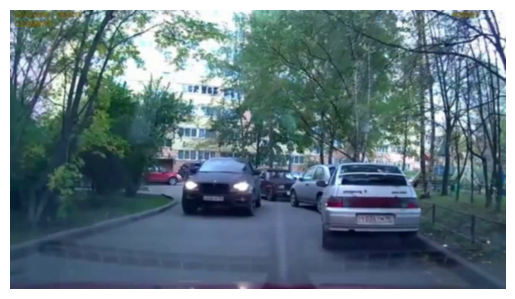

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 이미지 경로 설정
image_path = '/content/data/train/TRAIN_0000_frame_0001.jpg'

# 이미지 읽기
image = cv2.imread(image_path)

# 이미지가 제대로 읽혔는지 확인
if image is not None:
    # OpenCV는 BGR 포맷으로 이미지를 읽으므로, 이를 RGB로 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 이미지 출력
    plt.imshow(image_rgb)
    plt.axis('off')  # 축 표시 제거
    plt.show()
else:
    print(f"Failed to load image at {image_path}")

In [ ]:
image_rgb.shape

(720, 1280, 3)

## 시작

In [ ]:
# CSV 파일 불러오기
df = pd.read_csv('/content/drive/MyDrive/CarCrash_image/frame_metadata00.csv')

# label 업데이트
df.loc[df['image_name'].str.contains('TRAIN_2236|TRAIN_2596'), 'label'] = 0
df.loc[df['image_name'].str.contains('TRAIN_0061|TRAIN_0107|TRAIN_0123|TRAIN_0294|TRAIN_0800|TRAIN_1280|TRAIN_1590|TRAIN_2302|TRAIN_2548'), 'label'] = 1
df.loc[df['image_name'].str.contains('TRAIN_0056|TRAIN_0129|TRAIN_0149|TRAIN_0242|TRAIN_0263|TRAIN_0728|TRAIN_0861|TRAIN_0889|TRAIN_0896|TRAIN_0920|TRAIN_1098|TRAIN_1169|TRAIN_1251|TRAIN_1605|TRAIN_1654|TRAIN_1656|TRAIN_1698|TRAIN_1795|TRAIN_1839|TRAIN_1955|TRAIN_2249|TRAIN_2388|TRAIN_2647'), 'label'] = 3
df.loc[df['image_name'].str.contains('TRAIN_0221|TRAIN_0856|TRAIN_1081|TRAIN_1263|TRAIN_1488|TRAIN_1492|TRAIN_1874|TRAIN_2166|TRAIN_2555|TRAIN_2595|TRAIN_2622'), 'label'] = 4
df.loc[df['image_name'].str.contains('TRAIN_0017|TRAIN_0225|TRAIN_0306|TRAIN_1193|TRAIN_1771|TRAIN_1848|TRAIN_2140|TRAIN_2298|TRAIN_2532|TRAIN_2570'), 'label'] = 5
df.loc[df['image_name'].str.contains('TRAIN_0809'), 'label'] = 6
df.loc[df['image_name'].str.contains('TRAIN_0020|TRAIN_0507|TRAIN_0617|TRAIN_1023|TRAIN_1420|TRAIN_1531|TRAIN_2033|TRAIN_2063'), 'label'] = 7
df.loc[df['image_name'].str.contains('TRAIN_0332|TRAIN_0674|TRAIN_0720|TRAIN_0917|TRAIN_1287|TRAIN_1699|TRAIN_1923|TRAIN_1949|TRAIN_2239|TRAIN_2491|TRAIN_2534|TRAIN_2615'), 'label'] = 9
df.loc[df['image_name'].str.contains('TRAIN_0877|TRAIN_1728|TRAIN_2328|TRAIN_2685'), 'label'] = 10
df.loc[df['image_name'].str.contains('TRAIN_0341|TRAIN_1041|TRAIN_1581|TRAIN_1727|TRAIN_2607'), 'label'] = 11
df.loc[df['image_name'].str.contains('TRAIN_2571'), 'label'] = 12

# 삭제할 image_name 리스트 정리
del_list = ['TRAIN_0048', 'TRAIN_0234', 'TRAIN_0238', 'TRAIN_0325', 'TRAIN_0528', 'TRAIN_0554', 'TRAIN_0668',
            'TRAIN_0705', 'TRAIN_0875', 'TRAIN_1082', 'TRAIN_1151', 'TRAIN_1337', 'TRAIN_1362', 'TRAIN_1506',
            'TRAIN_1674', 'TRAIN_1681', 'TRAIN_1753', 'TRAIN_1838', 'TRAIN_2191', 'TRAIN_2356', 'TRAIN_2360',
            'TRAIN_2428', 'TRAIN_2451', 'TRAIN_2486', 'TRAIN_2558', 'TRAIN_2658']

# image_name 목록에 있는 행 삭제
pattern = '|'.join(del_list)
df = df[~df['image_name'].str.contains(pattern)]
df = df[df['label'] != 0]
# 데이터프레임 크기 확인
print(df.shape)

(44400, 3)


In [ ]:
# 경로 변경 함수 정의
def update_path(old_path):
    return old_path.replace('/content/drive/MyDrive/my_data/CarCrash_image/train00', '/content/data/train')

# image_path 열의 값 변경
df['image_path'] = df['image_path'].apply(update_path)
df.head(2)

,image_name,image_path,label
0,TRAIN_0000_frame_0000.jpg,/content/data/train/TRAIN_0000_frame_0000.jpg,7
1,TRAIN_0000_frame_0001.jpg,/content/data/train/TRAIN_0000_frame_0001.jpg,7


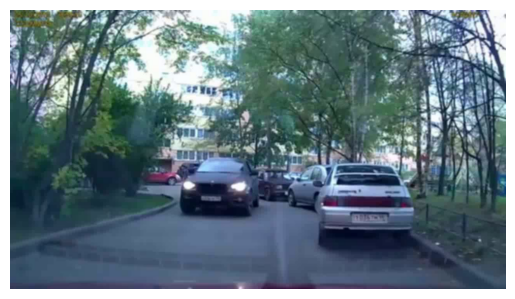

In [6]:
import cv2
import matplotlib.pyplot as plt

# 이미지 경로 설정
image_path = '/content/data/train/TRAIN_0000_frame_0000.jpg'

# 이미지 읽기
image = cv2.imread(image_path)

# 이미지가 제대로 읽혔는지 확인
if image is not None:
    # OpenCV는 BGR 포맷으로 이미지를 읽으므로, 이를 RGB로 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 이미지 출력
    plt.imshow(image_rgb)
    plt.axis('off')  # 축 표시 제거
    plt.show()
else:
    print(f"Failed to load image at {image_path}")

In [81]:
df = pd.read_csv('/content/drive/MyDrive/CarCrash_image/frame_metadata00.csv')
df[df['label'] == 2].iloc[[1722, 1923]]

,image_name,image_path,label
31622,TRAIN_1873_frame_0022.jpg,/content/drive/MyDrive/my_data/CarCrash_image/...,2
33623,TRAIN_1975_frame_0023.jpg,/content/drive/MyDrive/my_data/CarCrash_image/...,2


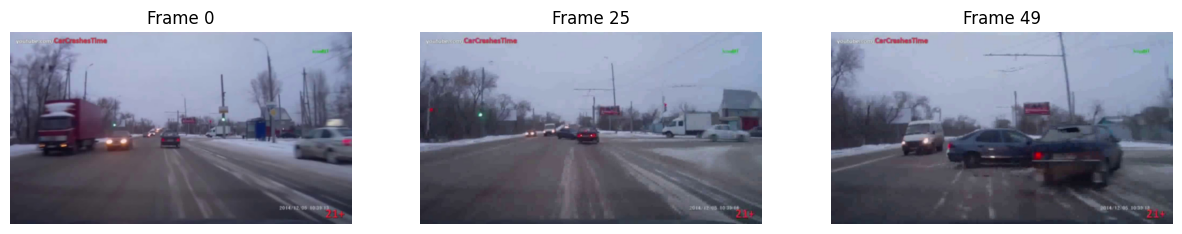

In [83]:
import cv2
import matplotlib.pyplot as plt
# 이미지 경로 설정
frame_indices = [0, 25, 49]
base_path = '/content/data/train/TRAIN_1923_frame_{:04d}.jpg'

# 그림 크기 설정
plt.figure(figsize=(15, 5))

# 각 프레임에 대해 이미지 읽기 및 출력
for i, frame_index in enumerate(frame_indices):
    image_path = base_path.format(frame_index)

    # 이미지 읽기
    image = cv2.imread(image_path)

    # 이미지가 제대로 읽혔는지 확인
    if image is not None:
        # OpenCV는 BGR 포맷으로 이미지를 읽으므로, 이를 RGB로 변환
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 서브플롯에 이미지 출력
        plt.subplot(1, 3, i+1)
        plt.imshow(image_rgb)
        plt.axis('off')  # 축 표시 제거
        plt.title(f'Frame {frame_index}')
    else:
        print(f"Failed to load image at {image_path}")

plt.show()

In [ ]:
&frames_list = ['frame_0000', 'frame_0025', 'frame_0049']
df = df[df['image_name'].apply(lambda x: any(x.endswith(frame + '.jpg') for frame in frames_list))]
df.shape

(2664, 3)

### weather에 대한 라벨 변경

In [ ]:
# normal
df.loc[df['label'].isin([1, 2, 7, 8]), 'label'] = 0

# snowy
df.loc[df['label'].isin([3, 4, 9, 10]), 'label'] = 1

# rainy
df.loc[df['label'].isin([5, 6, 11, 12]), 'label'] = 2

df['label'].value_counts()

label
0    1902
1     513
2     249
Name: count, dtype: int64

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.25, random_state=CFG['SEED'])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_path_list, label_list,transform):
        self.image_path_list = image_path_list
        self.label_list = label_list
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.image_path_list[index]
        image = self.get_image(img_path)
        if self.transform:
            image = self.transform(image)

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.image_path_list)


    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(img)

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),  # 랜덤으로 좌우 반전
    transforms.RandomRotation(degrees=25),  # 랜덤으로 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변형
    transforms.RandomResizedCrop(CFG['IMG_SIZE'], scale=(0.7, 1.0)),  # 랜덤 크롭 및 리사이즈
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = CustomDataset(train['image_path'].values, train['label'].values, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True,pin_memory=True, num_workers=0)

val_dataset = CustomDataset(val['image_path'].values, val['label'].values, transform=transform_val)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False,pin_memory=True, num_workers=0)

## Train

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_score_min = np.Inf

    def __call__(self, val_score, model, model_path):
        score = val_score
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(score, model, model_path)

    def save_checkpoint(self, val_score, model, model_path):
        if val_score < self.val_score_min:
            print(f'Validation score decreased ({self.val_score_min:.6f} --> {val_score:.6f}).  Saving model ...')
            torch.save(model.state_dict(), model_path)
        self.val_score_min = val_score

# 가중치 계산
#class_counts = [35800, 6450, 3500]
class_counts = [30000, 6000, 5000]
class_weights = [1.0 / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    #가중치 추가


    #criterion = nn.CrossEntropyLoss().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

    early_stop = EarlyStopping(patience=3, delta=0.001)
    best_val_score = 0
    best_model = None

    train_loss_epoch, valid_loss_epoch, valid_score_epoch = [], [], []
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for images, labels in tqdm(iter(train_loader)):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

        train_loss_epoch.append(_train_loss)
        valid_loss_epoch.append(_val_loss)
        valid_score_epoch.append(_val_score)

        if scheduler is not None:
            scheduler.step(_val_score)

        early_stop(_val_score, model, save_best_path)

        if early_stop.early_stop:
            print("Early stopping")
            break

        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
            print('***** Best Model *****')
            torch.save(best_model.state_dict(), save_best_path)

    return best_model, train_loss_epoch, valid_loss_epoch, valid_score_epoch

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []

    with torch.no_grad():
        for images, labels in tqdm(iter(val_loader)):
            images = images.to(device)
            labels = labels.to(device)

            logit = model(images)

            loss = criterion(logit, labels)

            val_loss.append(loss.item())

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()

        _val_loss = np.mean(val_loss)

    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            images = images.to(device)

            logit = model(images)

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)

In [ ]:
# model = models.resnet50(pretrained=True)
# model.fc = nn.Sequential(
#             nn.Linear(2048, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 3)
#         )

In [ ]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.05006] Val Loss : [0.92867] Val F1 : [0.51282]
Validation score decreased (inf --> 0.512822).  Saving model ...
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.84609] Val Loss : [0.75061] Val F1 : [0.62356]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.72886] Val Loss : [0.64119] Val F1 : [0.67673]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.64831] Val Loss : [0.58728] Val F1 : [0.70673]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.55554] Val Loss : [0.53949] Val F1 : [0.71767]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.50812] Val Loss : [0.51516] Val F1 : [0.72637]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.45387] Val Loss : [0.49203] Val F1 : [0.73467]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.40325] Val Loss : [0.49428] Val F1 : [0.74228]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.38578] Val Loss : [0.44453] Val F1 : [0.74617]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.36363] Val Loss : [0.42416] Val F1 : [0.77095]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.34733] Val Loss : [0.39927] Val F1 : [0.77725]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.30921] Val Loss : [0.42480] Val F1 : [0.74841]
EarlyStopping counter: 1 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.28135] Val Loss : [0.45361] Val F1 : [0.76906]
EarlyStopping counter: 2 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.26926] Val Loss : [0.40197] Val F1 : [0.78668]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.23883] Val Loss : [0.38020] Val F1 : [0.79628]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.23212] Val Loss : [0.38465] Val F1 : [0.79117]
EarlyStopping counter: 1 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.20773] Val Loss : [0.37444] Val F1 : [0.82012]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.19012] Val Loss : [0.37750] Val F1 : [0.81010]
EarlyStopping counter: 1 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.19528] Val Loss : [0.40148] Val F1 : [0.81581]
EarlyStopping counter: 2 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.18099] Val Loss : [0.36742] Val F1 : [0.82764]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.16606] Val Loss : [0.38367] Val F1 : [0.81440]
EarlyStopping counter: 1 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.14718] Val Loss : [0.37708] Val F1 : [0.81171]
EarlyStopping counter: 2 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.15722] Val Loss : [0.41617] Val F1 : [0.83136]
***** Best Model *****


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.15392] Val Loss : [0.37689] Val F1 : [0.80456]
EarlyStopping counter: 1 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.12860] Val Loss : [0.40756] Val F1 : [0.81594]
EarlyStopping counter: 2 out of 3


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.12097] Val Loss : [0.34537] Val F1 : [0.82217]
EarlyStopping counter: 3 out of 3
Early stopping


In [ ]:
# 마지막 분류레이어만 학습
# for name, param in model.named_parameters():
#     if "fc" in name:  # Unfreeze the final classification layer
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model, train_loss_epoch_, valid_loss_epoch_, valid_score_epoch_ = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.67323] Val Loss : [0.32119] Val F1 : [0.83343]
Validation score decreased (inf --> 0.833433).  Saving model ...
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.22413] Val Loss : [0.12741] Val F1 : [0.92895]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.11459] Val Loss : [0.07054] Val F1 : [0.96447]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.06649] Val Loss : [0.04597] Val F1 : [0.96872]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.04520] Val Loss : [0.04897] Val F1 : [0.97974]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.04057] Val Loss : [0.03579] Val F1 : [0.98528]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.02902] Val Loss : [0.02461] Val F1 : [0.98728]
***** Best Model *****


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.02537] Val Loss : [0.02014] Val F1 : [0.98579]
EarlyStopping counter: 1 out of 3


  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

### 예측

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 랜덤 프레임 하나 선택해서 inference

In [ ]:
class Video_to_image_Dataset(Dataset):
    def __init__(self, video_path_list, transform=None, label_list=None):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.transform = transform

    def __getitem__(self, index):
        frame = self.get_random_frame(self.video_path_list[index])
        if self.transform:
            frame = self.transform(frame)

        if self.label_list is not None:
            label = self.label_list[index]
            return frame, label
        else:
            return frame

    def __len__(self):
        return len(self.video_path_list)

    def get_random_frame(self, path):
        cap = cv2.VideoCapture(path)
        frame_count = CFG['VIDEO_LENGTH']

        # 랜덤한 프레임 번호 선택
        random_frame = np.random.randint(0, frame_count)
        cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)

        ret, frame = cap.read()
        cap.release()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(frame)

In [ ]:
test = pd.read_csv('/content/data1/test.csv')

test['video_path'] = test['video_path'].str.replace('./test', '/content/data1/test')

test_dataset = Video_to_image_Dataset(test['video_path'].values,transform = transform_test)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=0)

preds = inference(infer_model, test_loader, device)
submit = pd.read_csv('/content/data1/sample_submission.csv')
submit['label'] = preds
submit.to_csv(save_submit_path, index=False)

### 0, 25, 49번째 프레임 선택해서 예측

In [ ]:
class Video_to_image_Dataset(Dataset):
    def __init__(self, video_path_list, transform=None, label_list=None, frame_number=None):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.transform = transform
        self.frame_number = frame_number

    def __getitem__(self, index):
        frame = self.get_frame(self.video_path_list[index], self.frame_number)
        if self.transform:
            frame = self.transform(frame)

        if self.label_list is not None:
            label = self.label_list[index]
            return frame, label
        else:
            return frame

    def __len__(self):
        return len(self.video_path_list)

    def get_frame(self, path, frame_number):
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        ret, frame = cap.read()
        cap.release()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(frame)

In [ ]:
class Video_to_image_Dataset(Dataset):
    def __init__(self, video_path_list, transform=None, label_list=None, frame_number=None):
        self.video_path_list = video_path_list
        self.label_list = label_list
        self.transform = transform
        self.frame_number = frame_number

    def __getitem__(self, index):
        frame = self.get_frame(self.video_path_list[index], self.frame_number)  # 원하는 프레임 번호로 수정
        if self.transform:
            frame = self.transform(frame)

        if self.label_list is not None:
            label = self.label_list[index]
            return frame, label
        else:
            return frame
    def __len__(self):
        return len(self.video_path_list)

    def get_frame(self, path, frame_number):
        cap = cv2.VideoCapture(path)

        # 프레임 번호 설정
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        ret, frame = cap.read()
        cap.release()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(frame)

In [ ]:
test = pd.read_csv('/content/data1/test.csv')

test['video_path'] = test['video_path'].str.replace('./test', '/content/data1/test')

test_dataset = Video_to_image_Dataset(test['video_path'].values,transform = transform_test, frame_number=0)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=0)
preds1 = inference(infer_model, test_loader, device)

test_dataset = Video_to_image_Dataset(test['video_path'].values,transform = transform_test, frame_number=24)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=0)
preds2 = inference(infer_model, test_loader, device)

test_dataset = Video_to_image_Dataset(test['video_path'].values,transform = transform_test, frame_number=49)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=0)
preds3 = inference(infer_model, test_loader, device)

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/1800 [00:00<?, ?it/s]

In [ ]:
df_preds1 = pd.DataFrame(preds1, columns=['label'])
df_preds2 = pd.DataFrame(preds2, columns=['label'])
df_preds3 = pd.DataFrame(preds3, columns=['label'])

In [ ]:
print(df_preds1['label'].value_counts())
print(df_preds2['label'].value_counts())
print(df_preds3['label'].value_counts())

label
0    1288
2     296
1     216
Name: count, dtype: int64
label
0    1288
2     297
1     215
Name: count, dtype: int64
label
0    1313
2     269
1     218
Name: count, dtype: int64


In [ ]:
final_preds = []
for i in range(len(preds1)):
    vote = np.argmax(np.bincount([preds1[i], preds2[i], preds3[i]]))
    final_preds.append(vote)

In [ ]:
submit = pd.read_csv('/content/data1/sample_submission.csv')
submit['label'] = final_preds
submit.to_csv(save_submit_path, index=False)

### train 중 라벨 0에 대해 예측 후 사용

In [ ]:
# 모델 정의
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 3)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/CarCrash_image/model_checkpoint/best_weather_model_0608_대현_1.pth'))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


<All keys matched successfully>

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_path_list, transform, label_list=None):
        self.image_path_list = image_path_list
        self.label_list = label_list
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.image_path_list[index]
        image = self.get_image(img_path)
        if self.transform:
            image = self.transform(image)

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.image_path_list)

    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
        return Image.fromarray(img)

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    logits = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            images = images.to(device)
            logit = model(images)
            logits.append(logit.detach().cpu().numpy())
    return np.concatenate(logits, axis=0)

In [ ]:
CFG['IMG_SIZE']=224

In [ ]:
transform_val = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/CarCrash_image/train_image0.zip'

# 압축 해제할 경로 입력(드라이브 밖에 폴더로 설정해야함)
extraction_dir = '/content/data1'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [ ]:
train_0 = pd.read_csv('/content/drive/MyDrive/CarCrash_image/metadata0.csv')
train_0.head(2)

,image_name,image_path,label
0,TRAIN_0002_frame_0000.jpg,/content/data1/train_image_0/TRAIN_0002_frame_...,0
1,TRAIN_0002_frame_0001.jpg,/content/data1/train_image_0/TRAIN_0002_frame_...,0


In [ ]:
frames_list = ['frame_0000', 'frame_0025', 'frame_0049']
train_0 = train_0[train_0['image_name'].apply(lambda x: any(x.endswith(frame + '.jpg') for frame in frames_list))]
train_0.shape

(5352, 3)

In [ ]:
# 경로 변경 함수 정의
def update_path(old_path):
    return old_path.replace('/content/data1/train_image_0', '/content/data1')

# image_path 열의 값 변경
train_0['image_path'] = train_0['image_path'].apply(update_path)
train_0.head(2)

,image_name,image_path,label
0,TRAIN_0002_frame_0000.jpg,/content/data1/TRAIN_0002_frame_0000.jpg,0
25,TRAIN_0002_frame_0025.jpg,/content/data1/TRAIN_0002_frame_0025.jpg,0


In [ ]:
train_0 = train_0.reset_index(drop=True)

In [ ]:
dataset = CustomDataset(train_0['image_path'].values, transform=transform_val)
dataloader = DataLoader(dataset, batch_size = 1, shuffle=False, num_workers=0)
logits  = inference(model, dataloader, device)

  0%|          | 0/5352 [00:00<?, ?it/s]

In [ ]:
import torch.nn.functional as F

# Numpy 배열을 PyTorch 텐서로 변환
logits_tensor = torch.from_numpy(logits)

# 소프트맥스 함수를 사용하여 확률 값으로 변환
probabilities = F.softmax(logits_tensor, dim=1)
probabilities[0]

tensor([0.6432, 0.2107, 0.1461])

In [ ]:
probabilities_list = probabilities.tolist()
probabilities_df = pd.DataFrame(probabilities_list)

result_df = pd.concat([train_0, probabilities_df], axis=1)
result_df.head(2)

,image_name,image_path,label,0,1,2
0,TRAIN_0002_frame_0000.jpg,/content/data1/TRAIN_0002_frame_0000.jpg,0,0.643181,0.210732,0.146087
1,TRAIN_0002_frame_0025.jpg,/content/data1/TRAIN_0002_frame_0025.jpg,0,0.629905,0.189298,0.180797


In [ ]:
result_df[result_df[1]>0.8].shape, result_df[result_df[2]>0.8].shape

((167, 6), (351, 6))

In [ ]:
label1 = result_df[result_df[1] > 0.8].loc[:, ['image_name', 'image_path', 'label']]
label2 = result_df[result_df[2] > 0.8].loc[:, ['image_name', 'image_path', 'label']]

label1['label'] = 1
label2['label'] = 2

In [ ]:
label_0 = pd.concat([label1, label2], axis=0)
label_0['label'].value_counts()

label
2    351
1    167
Name: count, dtype: int64

In [ ]:
label_0.to_csv('/content/drive/MyDrive/CarCrash_image/add_metadata00.csv', index=False)